# 0.0. Imports

In [5]:
import numpy  as np
import pandas as pd
import boruta as bt
import scikitplot as skplt
import pickle

import seaborn as sns

from matplotlib import pyplot as plt

from sklearn import preprocessing   as pp
from sklearn import linear_model    as lm
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import neighbors       as nh

from imblearn   import combine         as c

ModuleNotFoundError: No module named 'numpy'

In [6]:
pd.options.mode.chained_assignment = None  # default='warn'

NameError: name 'pd' is not defined

In [15]:
!pip install pyplot

ERROR: Could not find a version that satisfies the requirement pyplot (from versions: none)
ERROR: No matching distribution found for pyplot


## 0.1. Helper Function

In [159]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [160]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

## 0.2. Load dataset

In [161]:
# Connect database
import pandas as pd
import psycopg2 as pg

In [162]:
# HOST = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
# PORT = '5432'
# DATABASE = 'comunidadedsdb'
# USER = 'member'
# PASSWORD ='cdspa'

# conn = pg.connect( host=HOST,
#                    database=DATABASE,
#                    port=PORT,
#                    user=USER,
#                    password=PASSWORD )

# query = """
#     SELECT *
#     FROM pa004.users u INNER JOIN pa004.vehicle v ON ( u.id = v.id )
#                        INNER JOIN pa004.insurance i ON ( u.id = i.id )
# """

# df1 = pd.read_sql( query, conn )

In [163]:
df_raw = pd.read_csv( '../data/raw/train.csv' )

In [164]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0. Data Description

In [165]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [166]:
# Setting the columns as lowercase
df1.columns = df1.columns.str.lower()

## 1.2. Data Dimensions

In [167]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 381109
Number of columns: 12


## 1.3. Data Types

In [168]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [169]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5. Data Descriptive

In [170]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.5.1. Numerical Attributes

In [171]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0. Feature Engineering

In [172]:
df2=df1.copy()

In [173]:
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

# 3.0. Data Filtering

In [174]:
df3=df2.copy()

# 4.0. Exploratoria Data Analysis

In [175]:
df4 = df3.copy()

In [176]:
df4['vehicle_age'].unique()

array(['over_2_years', 'between_1_2_year', 'below_1_year'], dtype=object)

## 4.1. Univariate Analysis

### 4.1.1. Age

<AxesSubplot:xlabel='response', ylabel='age'>

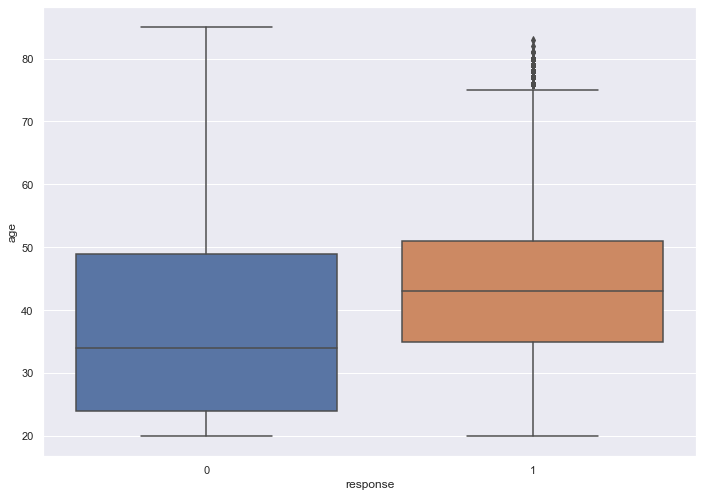

In [177]:
sns.boxplot (x='response', y='age', data=df4)

<AxesSubplot:xlabel='age', ylabel='Count'>

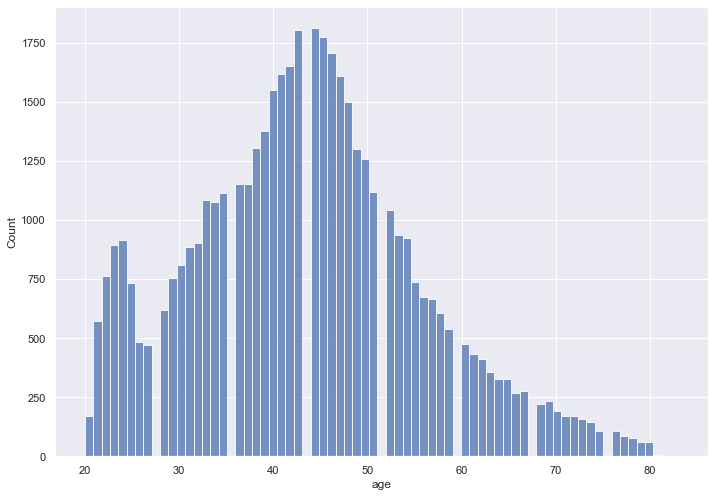

In [178]:
aux = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux)

<AxesSubplot:xlabel='age', ylabel='Count'>

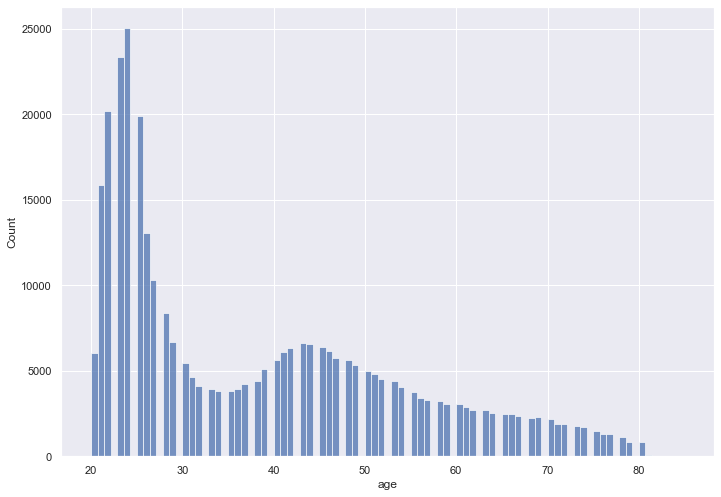

In [179]:
aux = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux)

### 4.1.2. Anual Premium

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

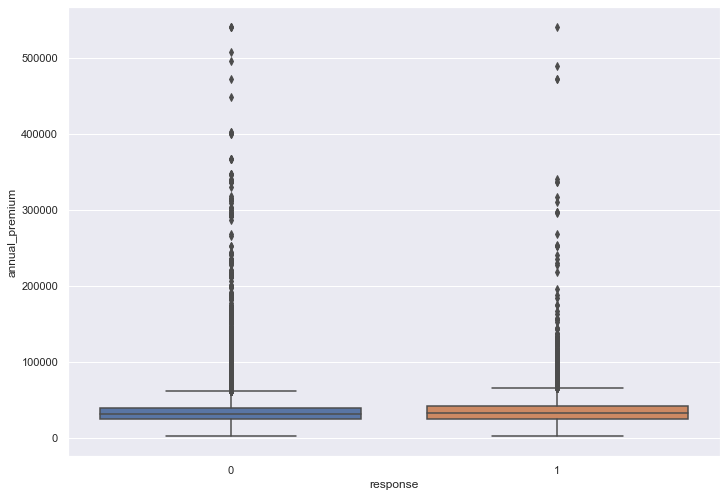

In [180]:
sns.boxplot(x='response', y='annual_premium', data=df4)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

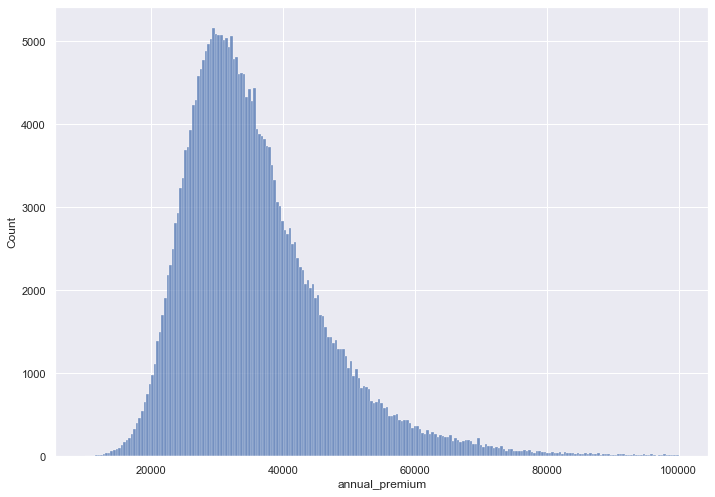

In [181]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 100000)]
aux1 = aux.loc[aux['response']==0, 'annual_premium']
sns.histplot(aux1)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

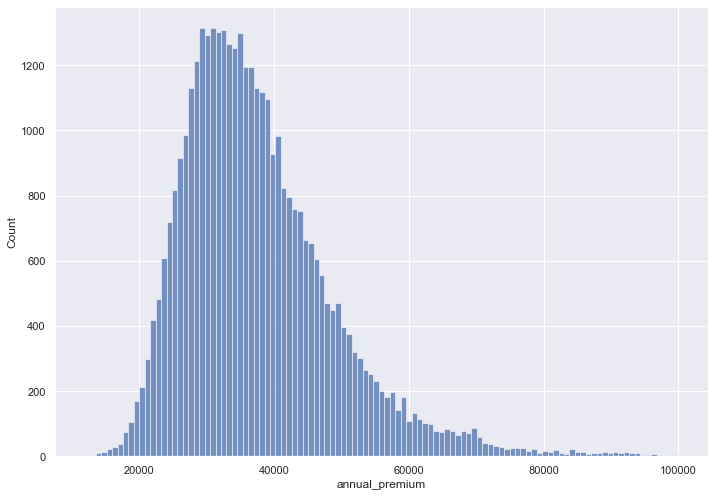

In [182]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 100000)]
aux1 = aux.loc[aux['response']==1, 'annual_premium']
sns.histplot(aux1)

### 4.1.3. Driving License

<AxesSubplot:xlabel='response', ylabel='driving_license'>

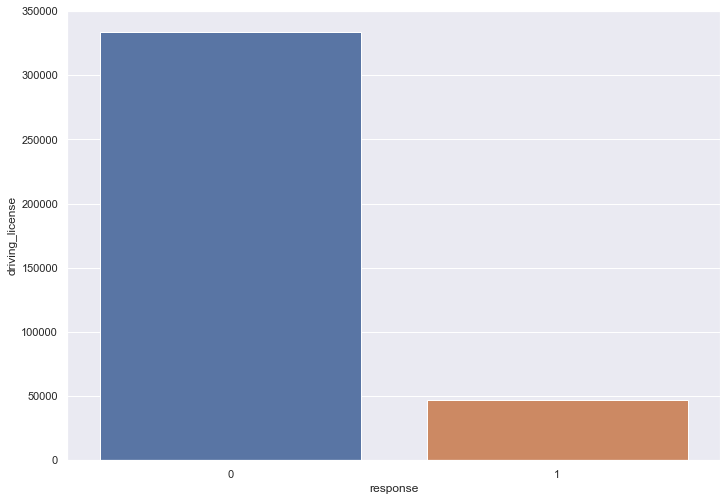

In [183]:
sns.barplot( x='response', y='driving_license', data=df4 )
aux1 = df4[['driving_license','response']].groupby('response').sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux1 )

### 4.1.4. Region Code

<AxesSubplot:xlabel='region_code', ylabel='id'>

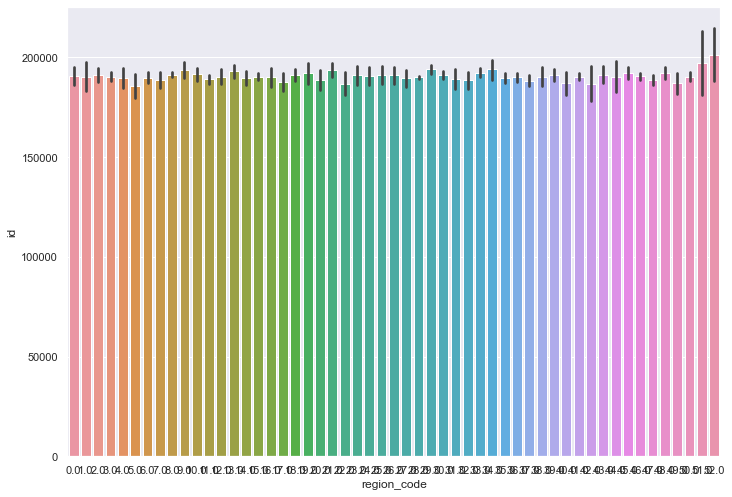

In [184]:
aux = df4[['id','region_code', 'response']]
sns.barplot(x='region_code', y='id', data=aux)

In [185]:
aux0 = df4[['region_code','id','response']].groupby(['region_code', 'response']).count().reset_index()
aux0

,region_code,response,id
0,0.0,0,1847
1,0.0,1,174
2,1.0,0,899
3,1.0,1,109
4,2.0,0,3751
...,...,...,...
101,50.0,1,642
102,51.0,0,155
103,51.0,1,28
104,52.0,0,234


### 4.1.5. Previously Insured

<AxesSubplot:xlabel='previously_insured', ylabel='id'>

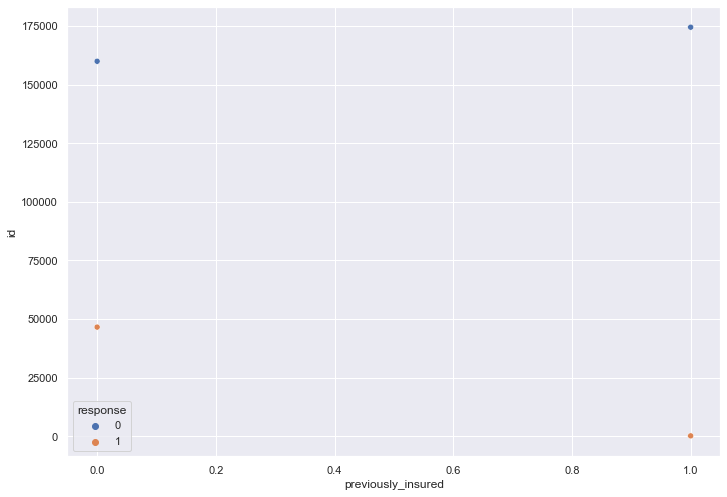

In [186]:
aux = df4[['previously_insured','response','id']].groupby(['previously_insured','response']).count().reset_index()
aux
sns.scatterplot( x='previously_insured', y='id', hue='response', data = aux )

In [187]:
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x / x.sum(), axis = 1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### 4.1.6. Vehicle Age

In [188]:
df4[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


In [189]:
df4[['id','vehicle_age', 'response']].groupby( ['vehicle_age', 'response'] ).count().reset_index() 

,vehicle_age,response,id
0,below_1_year,0,157584
1,below_1_year,1,7202
2,between_1_2_year,0,165510
3,between_1_2_year,1,34806
4,over_2_years,0,11305
5,over_2_years,1,4702


### 4.1.7. Vehicle Damage

<AxesSubplot:xlabel='response', ylabel='vehicle_damage'>

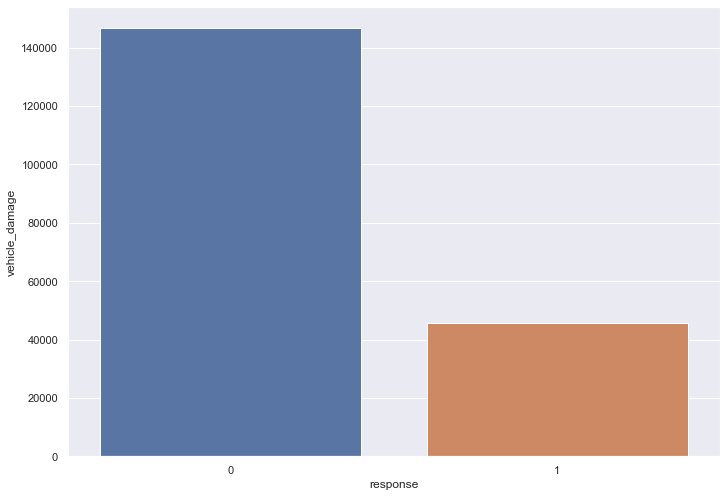

In [190]:
aux = df4[['vehicle_damage', 'response']].groupby('response').sum().reset_index()
sns.barplot( x='response', y='vehicle_damage', data=aux )

In [191]:
pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: x / x.sum(), axis = 1)

response,0,1
vehicle_damage,,
0,0.994796,0.005204
1,0.762345,0.237655


### 4.1.8. Policy Sales Channel

<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

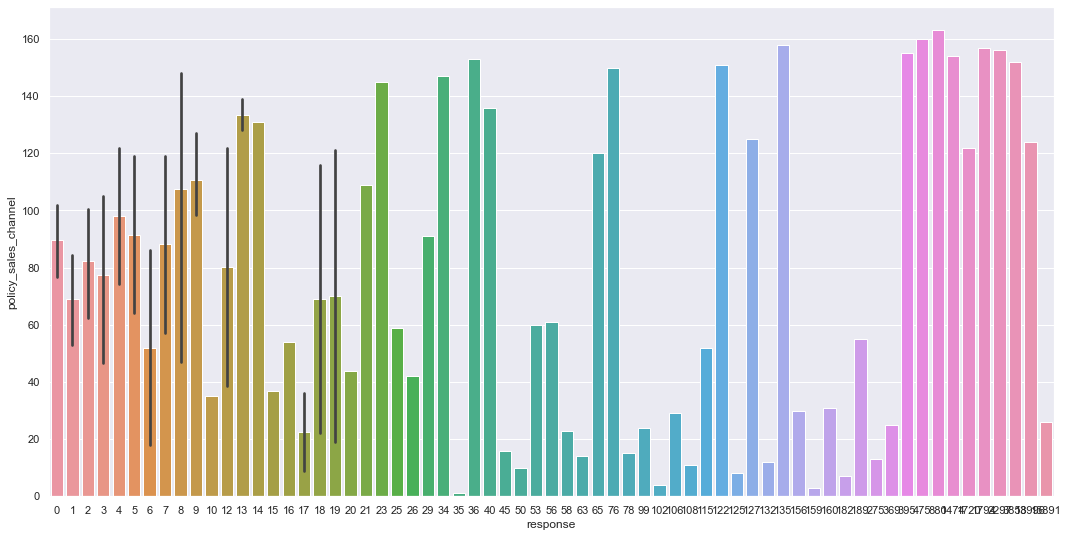

In [192]:
plt.figure(figsize=(18,9))
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=aux)

### 4.1.9. Vintage

<AxesSubplot:ylabel='Count'>

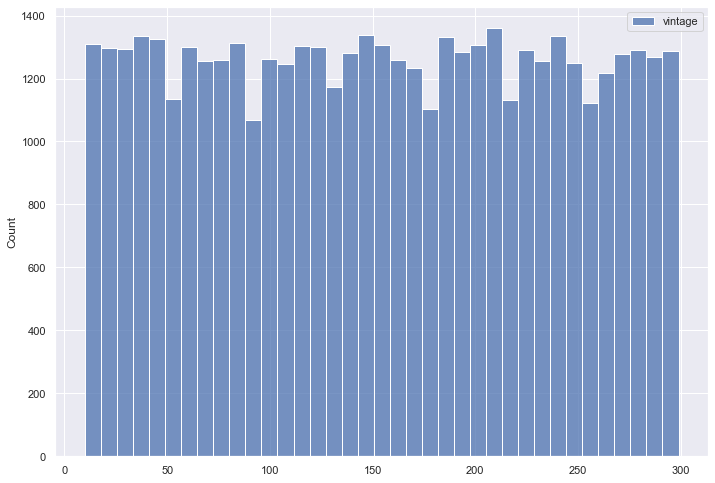

In [193]:
##Responders

aux = df4.loc[(df4['response']==1), ['vintage']]
sns.histplot(aux)

<AxesSubplot:ylabel='Count'>

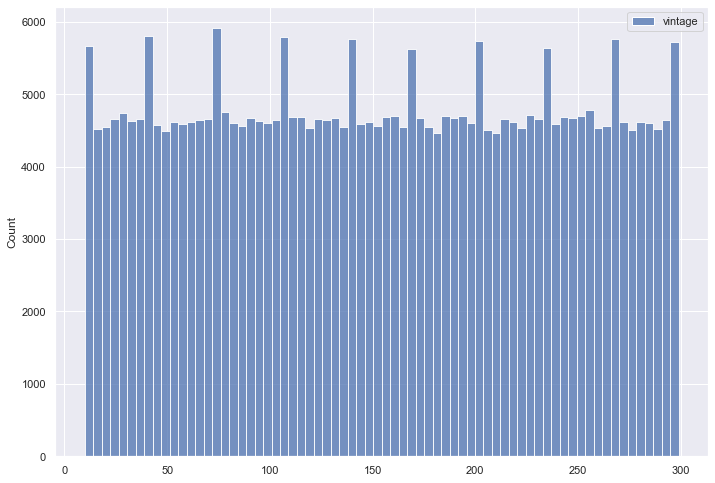

In [194]:
## Non-responders
aux = df4.loc[(df4['response']==0), ['vintage']]
sns.histplot(aux)

# 5.0. Data Preparation

## Balancing data

In [195]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
col_num = df4.select_dtypes(include=['int64', 'float64']).drop('response', axis=1).columns.tolist()

# Categorical
col_cat = df4.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] ).columns.tolist()

# encoding
df4_dummy = pd.DataFrame( ohe.fit_transform( df4[ col_cat] ).toarray(), index=df4.index )

# join numerical and categorical
df41 = pd.concat( [df4[col_num], df4_dummy], axis=1 )

In [196]:
#ratio for balancing

ratio_balanced = {0: 334399, 1: 8*37368}

# define sampler
smt = c.SMOTETomek( sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1 )

# apply sampler
X_smt, y_smt = smt.fit_resample( df41, df4['response'] )

In [197]:
# numerical data
df43 = X_smt[ col_num ]

# categorical data
df44 = X_smt.drop( col_num, axis=1 )
df45 = pd.DataFrame( ohe.inverse_transform( df44 ), columns=col_cat, index=df44.index )

# join numerical categorical
df46 = pd.concat( [df43, df45], axis=1 )
df46['response'] = y_smt

In [198]:
df46.head()

,id,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,gender,vehicle_age,response
0,1,44,1,28.0,0,1,40454.0,26.0,217,Male,over_2_years,1
1,2,76,1,3.0,0,0,33536.0,26.0,183,Male,between_1_2_year,0
2,3,47,1,28.0,0,1,38294.0,26.0,27,Male,over_2_years,1
3,4,21,1,11.0,1,0,28619.0,152.0,203,Male,below_1_year,0
4,5,29,1,41.0,1,0,27496.0,152.0,39,Female,below_1_year,0


## Splitting

In [199]:
df5 = df46.copy() 

In [200]:
x = df46.drop( 'response', axis=1 )
y = df46['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( x, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1. Standardization

In [201]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )

## 5.2. Rescaling

In [202]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
df5.head()

,id,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,gender,vehicle_age,response
72108,76675,0.523077,1,28.0,0,1,0.684442,157.000000,0.574394,Male,between_1_2_year,0
489694,83383,0.415385,1,28.0,0,1,0.131652,63.464728,0.193772,Female,between_1_2_year,1
387329,11763,0.538462,1,28.0,0,1,0.031496,26.000000,0.107266,Female,between_1_2_year,1
443,467,0.769231,1,8.0,0,1,0.875716,26.000000,0.826990,Male,between_1_2_year,0
134880,143361,0.015385,1,30.0,0,0,-0.629444,152.000000,0.968858,Female,below_1_year,0


## 5.3. Encoders

### 5.3.1. Encoding

In [203]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
df5.head()

,id,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,gender,response,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
72108,76675,0.523077,1,0.472086,0,1,0.684442,0.012174,0.574394,0.504778,0,0,1,0
489694,83383,0.415385,1,0.472086,0,1,0.131652,0.000002,0.193772,0.424266,1,0,1,0
387329,11763,0.538462,1,0.472086,0,1,0.031496,0.178536,0.107266,0.424266,1,0,1,0
443,467,0.769231,1,0.134743,0,1,0.875716,0.178536,0.826990,0.504778,0,0,1,0
134880,143361,0.015385,1,0.088103,0,0,-0.629444,0.217804,0.968858,0.424266,0,1,0,0


In [204]:
x_validation.head()

,id,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,gender,vehicle_age
65431,69510,73,1,28.0,0,1,49124.0,26.0,51,Female,between_1_2_year
315684,335597,21,1,11.0,1,0,27537.0,152.0,286,Female,below_1_year
357224,379800,48,1,8.0,1,0,37892.0,124.0,59,Male,between_1_2_year
93815,99728,46,1,28.0,0,1,40564.0,24.0,179,Male,between_1_2_year
48371,51389,24,1,8.0,1,0,32962.0,152.0,51,Male,below_1_year


## 5.4. Validation Preparation

In [205]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )
x_validation = x_validation.fillna( 0 )

# 6.0. Feature Selection

## 6.1. Feature Importance

In [206]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importances
0                   region_code     0.332433
0          policy_sales_channel     0.166173
0            previously_insured     0.119965
0                vehicle_damage     0.107819
0                       vintage     0.085736
0                annual_premium     0.083781
0                           age     0.069805
0      vehicle_age_below_1_year     0.021831
0  vehicle_age_between_1_2_year     0.006745
0      vehicle_age_over_2_years     0.003044
0                        gender     0.002385
0               driving_license     0.000283


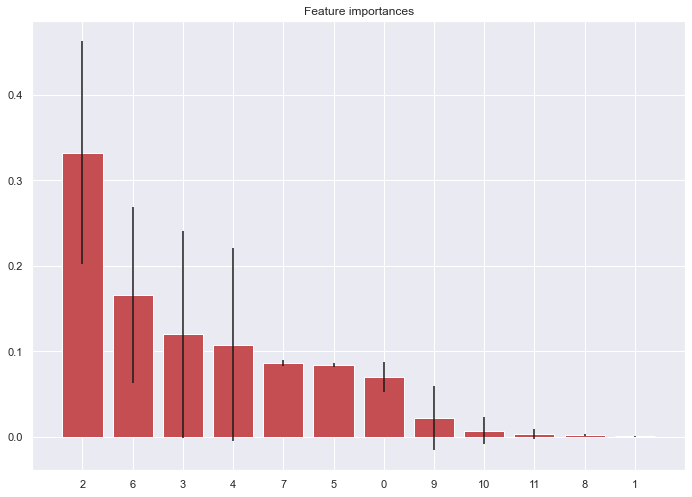

In [208]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importances': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importances', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

## 6.2. Boruta Algorithm

In [ ]:
# Yet to run Boruta

# 7.0. Machine Learning Modelling

In [209]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_train = df5[ cols_selected ]
x_val = x_validation[ cols_selected ]
y_val = y_validation.copy()

In [210]:
x_validation.head()

,id,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,gender,vehicle_age
65431,69510,0.815385,1,0.472086,0,1,1.043380,0.178536,0.141869,0.424266,between_1_2_year
315684,335597,0.015385,1,0.127727,1,0,-0.184768,0.217804,0.955017,0.424266,below_1_year
357224,379800,0.430769,1,0.134743,1,0,0.404358,0.152704,0.169550,0.504778,between_1_2_year
93815,99728,0.400000,1,0.472086,0,1,0.556376,0.001168,0.584775,0.504778,between_1_2_year
48371,51389,0.061538,1,0.134743,1,0,0.123876,0.217804,0.141869,0.504778,below_1_year


## 7.1. KNN Classifier

In [219]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=9 )

# model training
knn_model.fit( x_train, y_train )

# model prediction - Poder de GENERALIZACAO 
yhat_knn = knn_model.predict_proba( x_val )

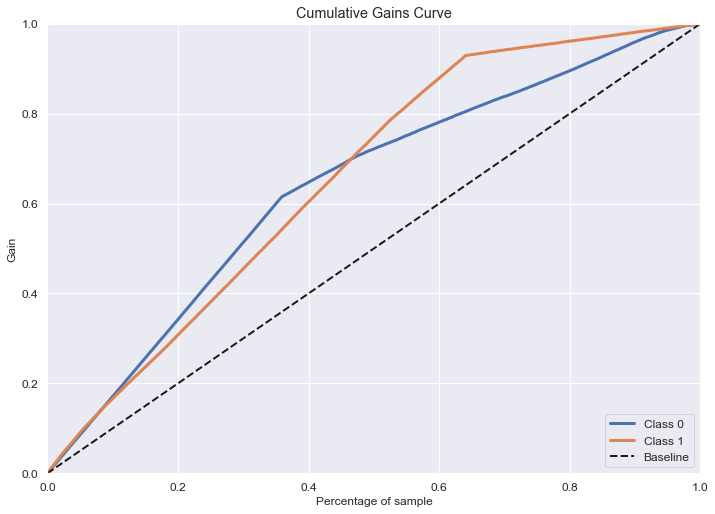

In [220]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

## 7.2. Logistic Regression

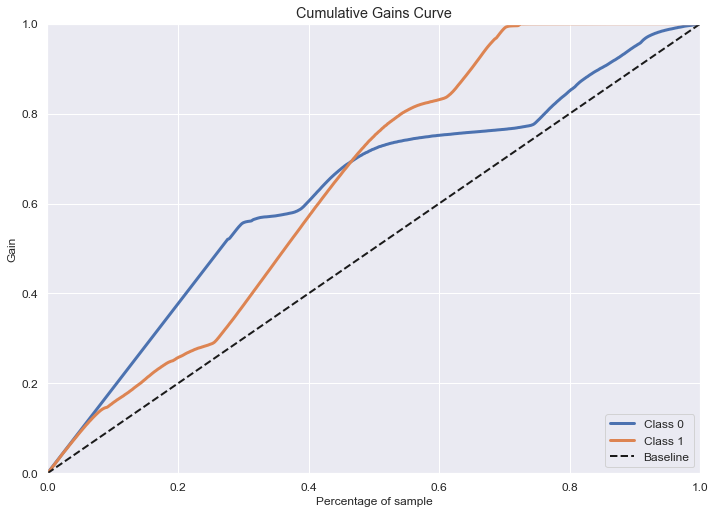

In [213]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

## 7.3. Extra Trees Classifier



In [214]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# model fit
et.fit( x_train, y_train )

# model predict
yhat_et = et.predict_proba( x_val )

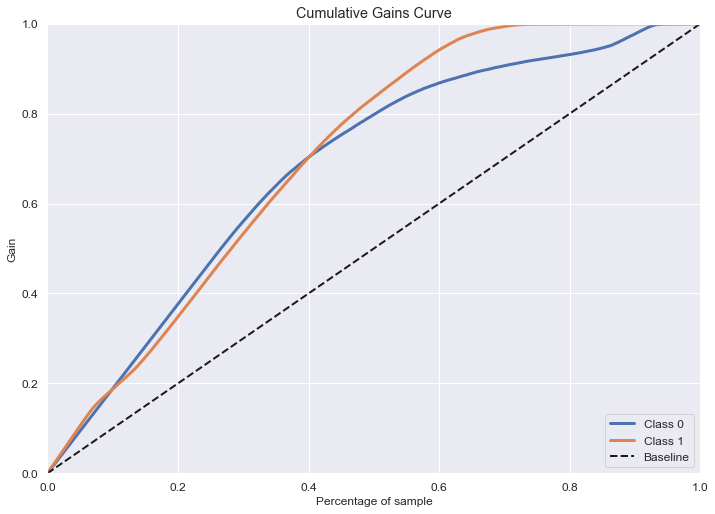

In [215]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et );

## 7.4 Random Forest

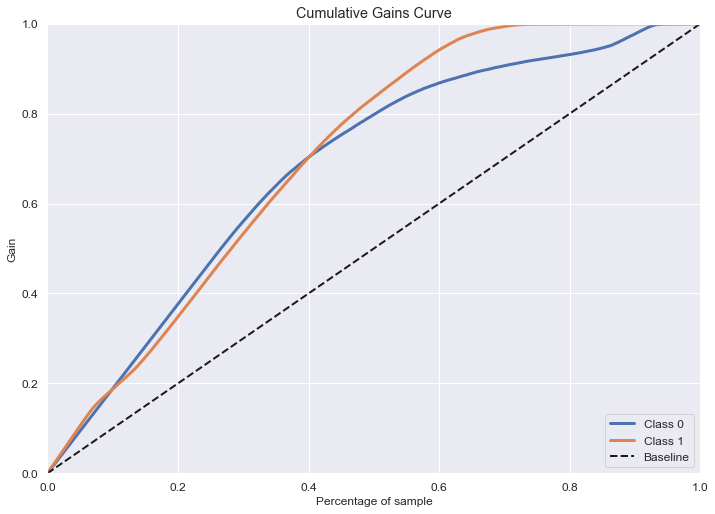

In [216]:
# model definition
rf = en.RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ) 

# model training
rf.fit( x_train, y_train )

# model prediction
yhat_rf = et.predict_proba( x_val )

skplt.metrics.plot_cumulative_gain( y_val, yhat_rf );

## 8.0. Performance Metrics

In [233]:
def precision_at_k( data, k=10 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return ( data.loc[ k, 'precision_at_k'], data )

In [234]:
def recall_at_k( data, k=15 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return ( data.loc[ k, 'recall_at_k'], data )

In [239]:
# copy dataframe
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_knn[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20, data = precision_at_k( df8, k=20 )

# compute recall at k
recall_at_15, data = recall_at_k( df8, k=15 )

# print scores

print('Precision at K: {}'.format (precision_at_20))
print('Recall at K: {}'.format (recall_at_15))

Precision at K: 0.9047619047619048
Recall at K: 0.0002695659987420253


# 9.0. Deploy to Production

## 9.1. Health Insurance Class

## 9.2. API Handler

## 9.3. API Tester